In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pvlib
import cpvlib

In [2]:
lat, lon = 40.4, -3.7

data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

data_tmy = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data_tmy = data_tmy.set_index(
    data_tmy.index.map(lambda t: t.replace(year=2010)))

data = data_tmy#['2010-06-01':'2010-06-01']

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=695, tz='utc')

solpos = location.get_solarposition(data.index)

In [3]:
# %% Parámetros
# R_sh_exp = 5.5, # exp. R paral VALOR_DEFECTO
# EgRef = 1.121, # VALOR_DEFECTO
# irrad_ref = 1000,
# temp_ref = 25

modulo = 'isofoton'

if modulo == 'ejemplo':
    # https://pvpmc.sandia.gov/PVLIB_Matlab_Help/html/pvl_calcparams_PVsyst_help.html
    pv_mod_params = {
        "alpha_sc": -0.002,  # coef. temp. Isc
        "gamma_ref": 1.1,  # "Datos básicos"
        "mu_gamma": -0.0003,  # "Parámetros modelo"
        "I_L_ref": 5.5,  # Isc
        "I_o_ref": 2.2e-9,  # "Datos básicos"
        "R_sh_ref": 200,  # R paral ref "Parámetros modelo"
        "R_sh_0": 8700,  # R paral G=0 W/m2 "Parámetros modelo"
        "R_s": 0.33,  # R serie "Parámetros modelo"
        "cells_in_series": 60,
    }

    A = 1.00  # m2

elif modulo == 'isofoton':
    # Isofoton_I110 - PVSyst
    pv_mod_params = {
        "alpha_sc": 2.3e-3,  # coef. temp. Isc
        "gamma_ref": 0.970,  # "Datos básicos"
        "mu_gamma": 0,  # "Parámetros modelo"
        "I_L_ref": 6.76,  # Isc
        "I_o_ref": 0.23e-9,  # "Datos básicos"
        "R_sh_ref": 200,  # R paral ref "Parámetros modelo"
        "R_sh_0": 800,  # R paral G=0 W/m2 "Parámetros modelo"
        "R_s": 0.248,  # R serie "Parámetros modelo"
        "cells_in_series": 36,
    }

    A = 0.85  # m2

In [4]:
#%% calcula Pmp STC
Pdc_stc = pvlib.pvsystem.singlediode(*cpvlib.StaticDiffuseSystem(
    module_parameters=pv_mod_params
).calcparams_pvsyst(
    effective_irradiance=1000,
    temp_cell=25))['p_mp']

eff_a = Pdc_stc / (1000 * A)
print(f'Pdc_stc={Pdc_stc:.0f} W, eff_a={eff_a:.2%}')

temp_mod_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['pvsyst']['freestanding']
# print(temp_mod_params)

Pdc_stc=110 W, eff_a=12.93%


In [5]:
# %% Modelo PVSyst
static_diffuse_sys = cpvlib.StaticDiffuseSystem(
    surface_tilt=37,
    surface_azimuth=180,
    # albedo=0.2,
    module_parameters=pv_mod_params,
    in_singleaxis_tracker=False,
    temperature_model_parameters=temp_mod_params,
    modules_per_string=1,
)

# AOI
aoi = static_diffuse_sys.get_aoi(
    solar_zenith=solpos['zenith'],
    solar_azimuth=solpos['azimuth'],
)
# aoi.plot()

irradiance = pvlib.irradiance.get_total_irradiance(
    static_diffuse_sys.surface_tilt, static_diffuse_sys.surface_azimuth,
    solar_zenith=solpos['zenith'], solar_azimuth=solpos['azimuth'],
    dni=data['dni'], ghi=data['ghi'], dhi=data['dhi']
)['poa_diffuse']

effective_irradiance = static_diffuse_sys.get_irradiance(
    solar_zenith=solpos['zenith'], solar_azimuth=solpos['azimuth'],
    aoi=aoi, aoi_limit=55,
    dni=data['dni'], ghi=data['ghi'], dhi=data['dhi']
)

cell_temp = static_diffuse_sys.pvsyst_celltemp(
    poa_diffuse_static=effective_irradiance,
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

diode_parameters = static_diffuse_sys.calcparams_pvsyst(
    effective_irradiance=effective_irradiance,
    temp_cell=cell_temp,
)

power = static_diffuse_sys.singlediode(
    *diode_parameters)


C:\Users\Ruben\Documents\GitHub\cpvlib\cpvlib.py:713: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)


In [6]:
Yr = irradiance.resample('M').sum() / 1000
Yr_effective = effective_irradiance.resample('M').sum() / 1000
Ya = power['p_mp'].resample('M').sum() / Pdc_stc

Lc = Yr - Ya
Lc_effective = Yr_effective - Ya

PR = Ya / Yr

print(f'PR={Ya.sum()/Yr.sum():.2}, Ya={Ya.sum():.0f} kWh/kW, Yr={Yr.sum():.0f} kWh/kW, Yr_effective={Yr_effective.sum():.0f} kWh/kW')

PR=1.5, Ya=790 kWh/kW, Yr=543 kWh/kW, Yr_effective=822 kWh/kW


<IPython.core.display.Javascript object>


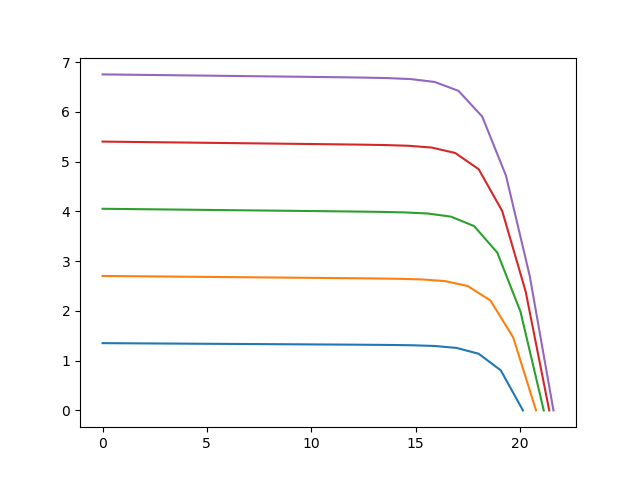

In [7]:
#%% Curvas IV vs G,Tc
plt.figure()
for G in [200, 400, 600, 800, 1000]:
    d = static_diffuse_sys.singlediode(*static_diffuse_sys.calcparams_pvsyst(
        effective_irradiance=G,
        temp_cell=25,
    ), ivcurve_pnts=20
    )
    plt.plot(d['v'], d['i'])


<IPython.core.display.Javascript object>


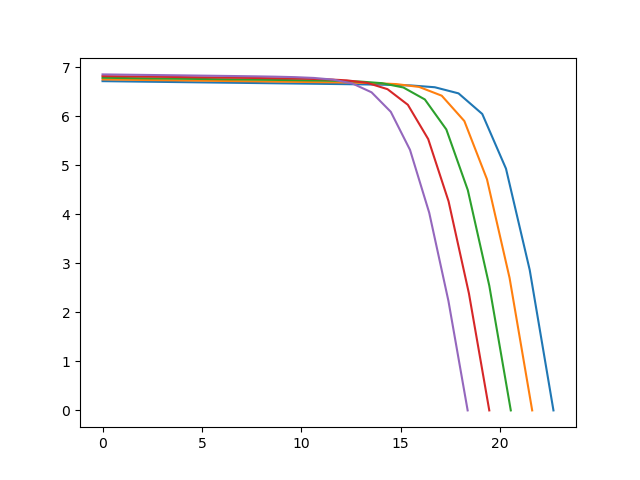

In [8]:
#%%
plt.figure()
for t in [10, 25, 40, 55, 70]:
    d = static_diffuse_sys.singlediode(*static_diffuse_sys.calcparams_pvsyst(
        effective_irradiance=1000,
        temp_cell=t,
    ), ivcurve_pnts=20
    )
    plt.plot(d['v'], d['i'])

<IPython.core.display.Javascript object>


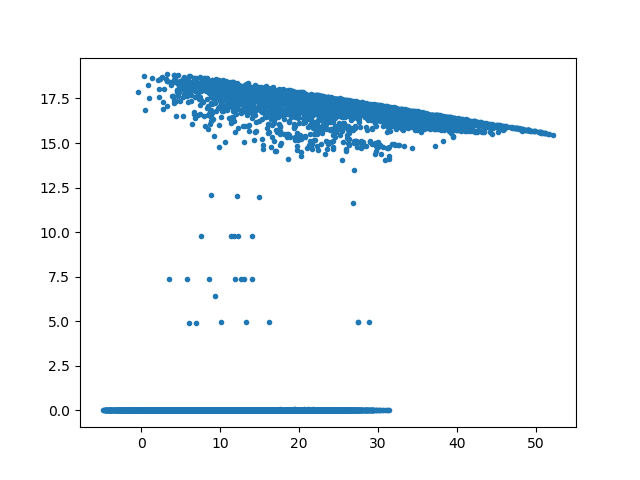

In [9]:
# %% Grafica V_mp vs cell_temp
plt.figure()
plt.plot(cell_temp, power['v_mp'], '.')

<IPython.core.display.Javascript object>


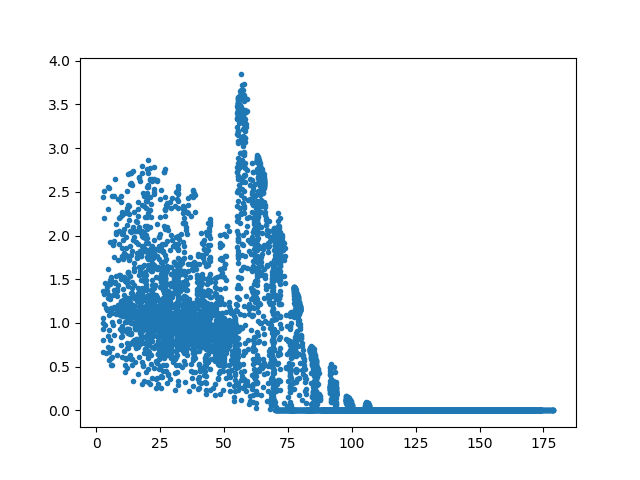

In [10]:
# %% Grafica I_mp vs aoi
plt.figure()
plt.plot(aoi, power['i_mp'], '.')